# Antikes Christentum und Sprache(n) – Digitale Mittel und Wege ausgehend vom Patristischen Textarchiv (PTA)

## Datengrundlage

### Texte im [Patristischen Textarchiv](https://pta.bbaw.de) ([Daten](https://github.com/PatristicTextArchive/pta_data))
- Statistische Daten in <https://github.com/PatristicTextArchive/pta_metadata/blob/main/pta_grc_statistics.json> im json-Format (generiert mit <https://github.com/PatristicTextArchive/pta_metadata/blob/main/scripts/pta_lemmatize_cltk.py>)
    - verwendetes Tool: [CLTK](http://cltk.org/) (gepatched), das für diese Aufgabe auf [OdyCy](https://centre-for-humanities-computing.github.io/odyCy/) zurückgreift.
    - enthält für jeden Text (identifziert durch PTA-URN): Wort, Lemma, POS-Tag (cf. <https://universaldependencies.org/u/pos/>), Morphologische Analyse (cf. <https://universaldependencies.org/u/feat/index.html>), Syntaxanalyse (cf. https://universaldependencies.org/u/dep/index.html) sortiert nach Häufigkeit des Vorkommens und ohne Filterung von Stopwords. **Achtung**: nicht fehlerfrei!
- Lemmatisierte Texte in <https://github.com/PatristicTextArchive/pta_data_plaintext> im plaintext-Format (generiert ebenfalls mit <https://github.com/PatristicTextArchive/pta_metadata/blob/main/scripts/pta_lemmatize_cltk.py>)
- Weitere Version *ohne Zitate* (nur die Dateien, in denen Zitate ausgezeichnet sind)
    - Statistische Daten [data/analyses/pta_noquotes_grc_statistics.json](data/analyses/pta_noquotes_grc_statistics.json) im json-Format (generiert mit [otherscripts/tlg_lemmatize_cltk_grc.py](otherscripts/pta_no-quotes_lemmatize_cltk_grc.py))
    - Lemmatisierte Texte im Ordner [data/lemmatized](data/lemmatized) (`_noquotes` im Dateinamen)

### Briefe von Basilius von Caesarea, Gregor von Nazianz, Gregor von Nyssa, Libanius, Synesius, Julian und Theodoret von Kyrrhos (Quelle: TLG-E)
- in UTF-8 konvertiert, mit [otherscripts/get_tlg_files.ipynb](otherscripts/get_tlg_files.ipynb) (erzeugt auch Dateien für jeden einzelnen Brief)
    - verwendetes Tool: [CLTK](http://cltk.org/)
- IDs: 
    - Basilius = tlg2040-004
    - Gregor von Nazianz = tlg2022-001
    - Gregor von Nyssa = tlg2017-033
    - Theodoret = tlg4089-005 (Collectio Patmensis) und tlg4089-006+007 (Collectio Sirmondiana)
    - Libanius = tlg2200-001
    - Synesius = tlg2006-001
    - Julian = tlg2003-013
- allgemeine Statistik zu den Briefen in [statistics/letters_statistics.csv](statistics/letters_statistics.csv) (Autor, Briefnummer, Adressat, Anzahl der Worte)
- Statistische Daten: [data/analyses/letters_grc_statistics.json](data/analyses/letters_grc_statistics.json) im json-Format (generiert mit [otherscripts/tlg_lemmatize_cltk_grc.py](otherscripts/tlg_lemmatize_cltk_grc.py))
    - verwendetes Tool: [CLTK](http://cltk.org/) (gepatched), das für diese Aufgabe auf [OdyCy](https://centre-for-humanities-computing.github.io/odyCy/) zurückgreift. **Achtung**: nicht fehlerfrei!
    - enthält für jeden Text (identifziert durch TLG-ID): Wort, Lemma, POS-Tag (cf. <https://universaldependencies.org/u/pos/>), Morphologische Analyse (cf. <https://universaldependencies.org/u/feat/index.html>), Syntaxanalyse (cf. https://universaldependencies.org/u/dep/index.html) sortiert nach Häufigkeit des Vorkommens und ohne Filterung von Stopwords
- Lemmatisierte Texte im Ordner [data/lemmatized](data/lemmatized)



## Experimente

### Funktionen

In [369]:
# Importe
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt

In [481]:
# Funktionen
def add_wordcount(dataframe):
    """Fügt eine Spalte hinzu, die die Gesamtzahl
    der Worte ethält"""
    dataframe.set_index('urn', inplace=True) # urn als Index
    dataframe['wordcount'] = dataframe['tokens'].apply(count) # weitere Spalte mit Summe der Worte im Text 

def count(mylist):
    """Summiert den Inhalt einer Zelle im Format
    [[item, count]]"""
    return sum([x[1] for x in mylist])

def count_listitems(mylist):
    """Summiert die Anzahl der Listeinträge in einer
    Zelle im Format [[item, count]]"""
    return len([x[0] for x in mylist])

def sort_listitems(mylist):
    """Sortiert die Liste"""
    return sorted(mylist)

def get_keys(mylist):
    """Erzeugt eine Liste der Keys in einer Zeile
    im Format [[item, count]]"""
    return [x[0] for x in mylist]

def get_value(mylist):
    """Extrahiert den Wert zu einem Key in einem
    Eintrag im Format [item, count]"""
    return [x[1] for x in mylist]

def split_df_columns(dataframe,column):
    """Splits a column in a dataframe to columns 
    according to the entries in the column
    in format [[item, count]] and drops
    the original column
    use as: split_df_columns(dataframe, 'column')"""
    dataframe = dataframe.reset_index()
    maxrow = dataframe[column].apply(count_listitems).idxmax()
    keys = sorted([x[0] for x in dataframe.loc[maxrow,column]])
    split = pd.DataFrame(dataframe[column].apply(sorted).apply(get_value).to_list(), columns = keys)
    df = pd.concat([dataframe, split], axis=1)
    df.fillna(0, inplace=True)
    df.drop(columns=column, inplace=True)
    df.set_index('urn', inplace=True) # urn als Index
    return df

def feature_frequency(dataframe):
    """Calculates document frequency of feature and drops
    wordcount afterwards, rewrites the dataframe"""
    dataframe.iloc[:,1:] = dataframe.iloc[:,1:].div(dataframe.iloc[:,0], axis=0)
    dataframe.drop(columns="wordcount", inplace=True)
    return dataframe

def plot_feature(dataframe):
    dataframe.plot(kind='barh', stacked=True, figsize=(8, 6), rot=0, xlabel='Anteil', ylabel='URN', colormap="tab20b")
    plt.title("Verteilung der Tags")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)  

### Laden der Daten

In [ ]:
# PTA Statistik laden
url = ("https://raw.githubusercontent.com/PatristicTextArchive/pta_metadata/main/pta_grc_statistics.json")
r = requests.get(url, headers={'Content-Type': 'application/json'})
j = r.json()
ptastats = pd.DataFrame.from_dict(j)


In [505]:
# PTA-Statistik aus lokalem Repositorium laden
with open("../pta_metadata/pta_grc_statistics.json") as pta:
    ptastats = pd.read_json(pta)

In [506]:
add_wordcount(ptastats)

In [508]:
# PTA-Statistik (ohne quotes) laden
with open("data/analyses/pta_noquotes_grc_statistics.json") as quotes:
    pta_noquotes = pd.read_json(quotes)

In [509]:
add_wordcount(pta_noquotes)

In [510]:
# Briefe-Statistik laden
with open("data/analyses/letters_grc_statistics.json") as epp:
    letters = pd.read_json(epp)

In [511]:
add_wordcount(letters)

Es stehen nun als Daten zur Verfügung:
- `ptastats` (PTA-Texte)
- `pta_noquotes` (PTA-Texte ohne Zitate)
- `letters` (Briefkorpus aus TLG)


### Biblische Sprache?

#### IDs

- Pentateuch: pta9999.pta001-pta9999.pta005
- Psalmen pta9999.pta031
- Propheten pta9999.pta040-pta053
- Evangelien und Apostelgeschichte pta9999.pta063-pta067
- Paulinen (+Pseudo) pta9999.pta068-pta081
- Katholische Briefe pta9999.pta082-pta088


In [417]:
pentateuch_pos = ptastats.loc["urn:cts:pta:pta9999.pta001":"urn:cts:pta:pta9999.pta006", ["pos", "wordcount"]] 
pentateuch_syntax = ptastats.loc["urn:cts:pta:pta9999.pta001":"urn:cts:pta:pta9999.pta006", ["syntax", "wordcount"]] 
psalmen_pos = ptastats.loc["urn:cts:pta:pta9999.pta031":"urn:cts:pta:pta9999.pta032", ["pos", "wordcount"]] 
psalmen_syntax = ptastats.loc["urn:cts:pta:pta9999.pta031":"urn:cts:pta:pta9999.pta032", ["syntax", "wordcount"]] 
propheten_pos = ptastats.loc["urn:cts:pta:pta9999.pta040":"urn:cts:pta:pta9999.pta054", ["pos", "wordcount"]] 
propheten_syntax = ptastats.loc["urn:cts:pta:pta9999.pta040":"urn:cts:pta:pta9999.pta054", ["syntax", "wordcount"]] 


In [434]:
pentateuch_syntax_tags = feature_frequency(split_df_columns(pentateuch_syntax,"syntax"))
pentateuch_pos_tags = feature_frequency(split_df_columns(pentateuch_pos,"pos"))

In [443]:
propheten_syntax_tags = feature_frequency(split_df_columns(propheten_syntax,"syntax"))
propheten_pos_tags = feature_frequency(split_df_columns(propheten_pos,"pos"))

In [ ]:
#pentateuch_syntax_tags.describe()
#pentateuch_syntax_tags[['parataxis', 'advcl']].plot(kind="box")

In [452]:
pentateuch_syntax_tags.loc["mean"] = pentateuch_syntax_tags.mean(axis = 0, skipna = True) 
pentateuch_pos_tags.loc["mean"] = pentateuch_pos_tags.mean(axis = 0, skipna = True)
propheten_syntax_tags.loc["mean"] = propheten_syntax_tags.mean(axis = 0, skipna = True) 
propheten_pos_tags.loc["mean"] = propheten_pos_tags.mean(axis = 0, skipna = True)

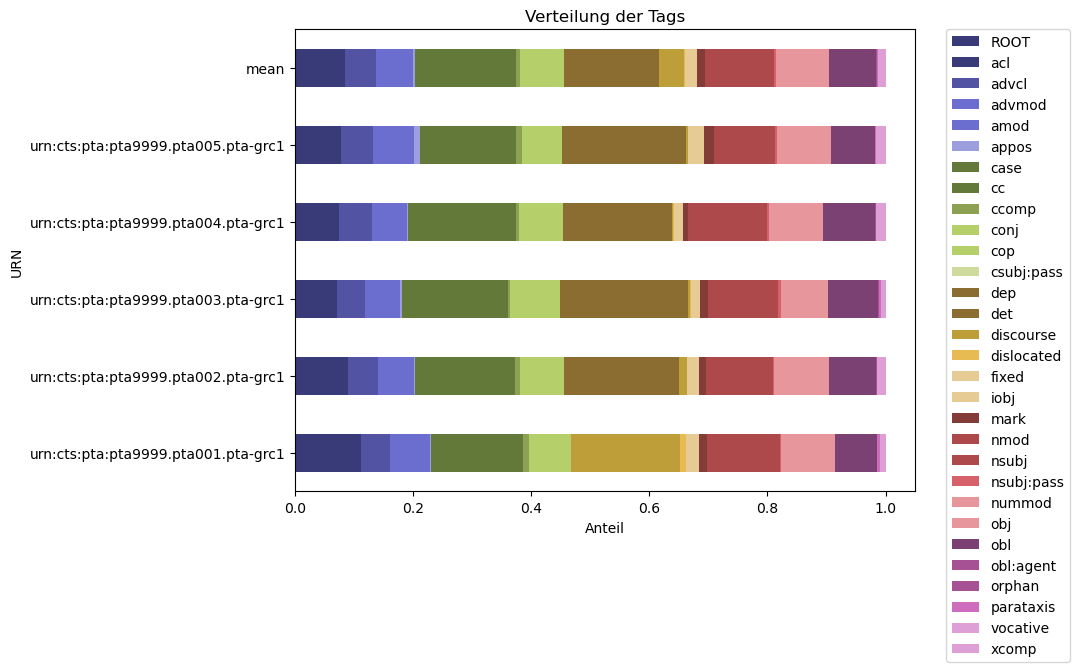

In [436]:
plot_feature(pentateuch_syntax_tags)


#### Pastor Hermae


In [437]:
pastor = ptastats.loc["urn:cts:pta:pta0038.pta001":"urn:cts:pta:pta0039.pta001"]
pastor.head()

,tokens,lemmata,pos,morphology,syntax,wordcount
urn,,,,,,
urn:cts:pta:pta0038.pta001.pta-grc1,"[[καὶ, 1524], [ , 581], [δὲ, 551], [τοῦ, 491],...","[[ὁ, 3606], [καί, 1524], [αὐτός, 823], [δέ, 59...","[[VERB, 4894], [NOUN, 4451], [DET, 3896], [ADV...","[[Case: [accusative], Gender: [feminine], Numb...","[[det, 4180], [advmod, 2380], [ROOT, 2267], [o...",23865


In [453]:
# select pos, syntax and wordcount into new dataframe
pastor_pos = ptastats.loc["urn:cts:pta:pta0038.pta001":"urn:cts:pta:pta0039.pta001", ["pos", "wordcount"]] 
pastor_syntax = ptastats.loc["urn:cts:pta:pta0038.pta001":"urn:cts:pta:pta0039.pta001", ["syntax", "wordcount"]]

In [454]:
pastor_syntax_tags = feature_frequency(split_df_columns(pastor_syntax,"syntax"))
pastor_pos_tags = feature_frequency(split_df_columns(pastor_pos,"pos"))

In [455]:
vergleich_syntax = pd.concat([pentateuch_syntax_tags,pastor_syntax_tags])
vergleich_pos = pd.concat([pentateuch_pos_tags,pastor_pos_tags])
vergleich_syntax_pr = pd.concat([propheten_syntax_tags,pastor_syntax_tags])
vergleich_pos_pr = pd.concat([propheten_pos_tags,pastor_pos_tags])

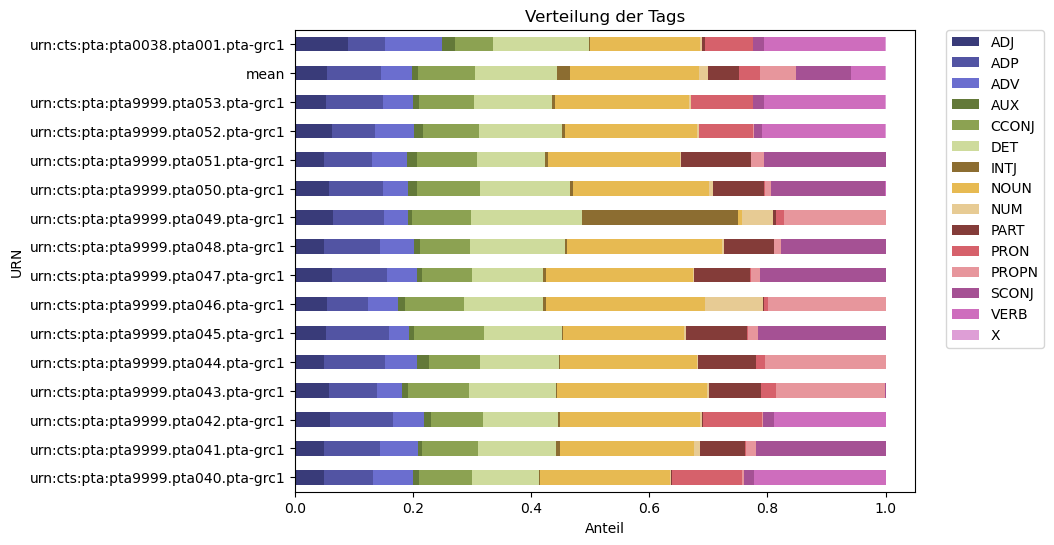

In [456]:
plot_feature(vergleich_pos_pr)

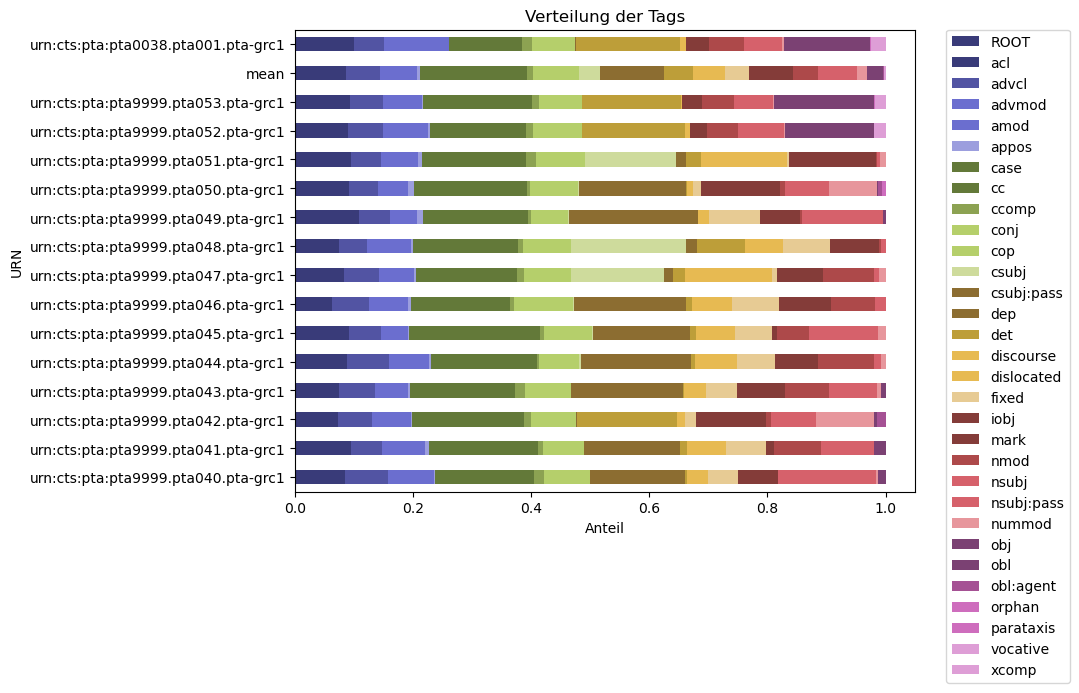

In [457]:
plot_feature(vergleich_syntax_pr)


#### Text ohne Zitate
am Beispiel der homilia in Ps 96 des Severian von Gabala (pta0001.pta006) und der epistula ad Dracontium des Athanasius (pta0022.pta013)


In [545]:
epdrac_pos = ptastats.loc["urn:cts:pta:pta0001.pta006":"urn:cts:pta:pta0001.pta007", ["pos", "wordcount"]] 
epdrac_syntax = ptastats.loc["urn:cts:pta:pta0001.pta006":"urn:cts:pta:pta0001.pta007", ["syntax", "wordcount"]] 
epdrac_nq_pos = pta_noquotes.loc["urn:cts:pta:pta0001.pta006":"urn:cts:pta:pta0001.pta007", ["pos", "wordcount"]] 
epdrac_nq_syntax = pta_noquotes.loc["urn:cts:pta:pta0001.pta006":"urn:cts:pta:pta0001.pta007", ["syntax", "wordcount"]] 

In [550]:
epdrac_syntax_tags = split_df_columns(epdrac_syntax,"syntax")
epdrac_pos_tags = split_df_columns(epdrac_pos,"pos")
epdrac_nq_syntax_tags = split_df_columns(epdrac_nq_syntax,"syntax")
epdrac_nq_pos_tags = split_df_columns(epdrac_nq_pos,"pos")

In [551]:
vergleich_syntax_epdrac = pd.concat([epdrac_syntax_tags,epdrac_nq_syntax_tags])
vergleich_pos_epdrac = pd.concat([epdrac_pos_tags,epdrac_nq_pos_tags])

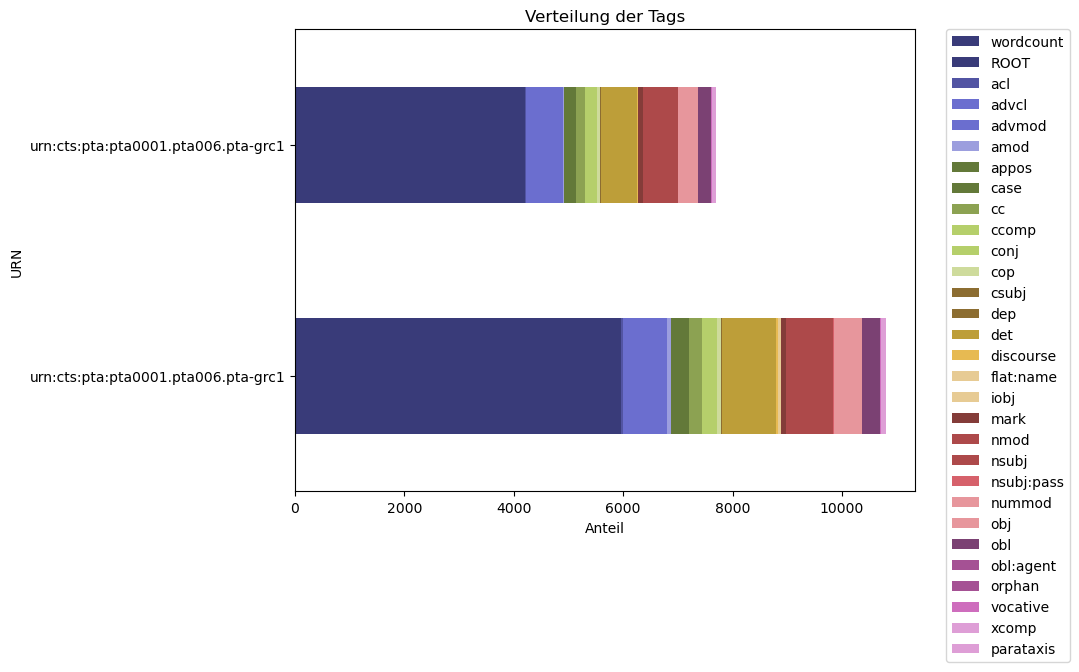

In [552]:
plot_feature(vergleich_syntax_epdrac)


### Christliche Sprache?


In [513]:
letters.head()

,tokens,lemmata,pos,morphology,syntax,wordcount
urn,,,,,,
tlg2003-013,"[[καὶ, 991], [δὲ, 510], [τῶν, 341], [μὲν, 241]...","[[ὁ, 2394], [καί, 1002], [δέ, 586], [ἐγώ, 345]...","[[VERB, 3649], [NOUN, 3255], [ADV, 2559], [ADJ...","[[Case: [accusative], Gender: [neuter], Number...","[[advmod, 3263], [det, 2405], [obj, 1852], [nm...",19765
tlg2006-001,"[[καὶ, 2056], [δὲ, 769], [τὴν, 558], [τῶν, 529...","[[ὁ, 4810], [καί, 2073], [δέ, 897], [εἰμί, 722...","[[VERB, 7367], [NOUN, 6867], [DET, 4783], [ADV...","[[Case: [accusative], Gender: [neuter], Number...","[[advmod, 6090], [det, 4882], [obj, 3834], [nm...",39160
tlg2017-033,"[[καὶ, 852], [τῆς, 432], [τὴν, 423], [τὸ, 400]...","[[ὁ, 3465], [καί, 866], [εἰμί, 308], [ἐν, 293]...","[[NOUN, 3851], [DET, 3573], [VERB, 2874], [ADJ...","[[Case: [accusative], Gender: [feminine], Numb...","[[det, 3631], [nmod, 2057], [advmod, 1952], [c...",18788
tlg2022-001,"[[καὶ, 2992], [δὲ, 702], [τὸ, 672], [τὴν, 663]...","[[ὁ, 5426], [καί, 3035], [δέ, 901], [ἐγώ, 740]...","[[VERB, 7423], [NOUN, 6417], [DET, 5385], [ADJ...","[[Case: [accusative], Gender: [neuter], Number...","[[advmod, 6877], [det, 5501], [obj, 4144], [nm...",41737
tlg2040-004,"[[καὶ, 6418], [τὴν, 2733], [τῆς, 2712], [τῶν, ...","[[ὁ, 21991], [καί, 6488], [δέ, 2329], [αὐτός, ...","[[NOUN, 25548], [VERB, 23597], [DET, 22616], [...","[[Case: [accusative], Gender: [feminine], Numb...","[[det, 23293], [advmod, 16644], [nmod, 13214],...",134471


In [533]:
pag_letters_pos = letters.loc[["tlg2200-001","tlg2006-001","tlg2003-013"], ["pos", "wordcount"]] 
pag_letters_syntax = letters.loc[["tlg2200-001","tlg2006-001","tlg2003-013"], ["syntax", "wordcount"]] 
pag_letters_syntax_tags = feature_frequency(split_df_columns(pag_letters_syntax,"syntax"))
pag_letters_pos_tags = feature_frequency(split_df_columns(pag_letters_pos,"pos"))
pag_letters_syntax_tags.loc["mean_pag"] = pag_letters_syntax_tags.mean(axis = 0, skipna = True) 
pag_letters_pos_tags.loc["mean_pag"] = pag_letters_pos_tags.mean(axis = 0, skipna = True)

In [526]:
chr_letters_pos = letters.loc[["tlg2040-004","tlg2022-001","tlg2017-033","tlg4089-005","tlg4089-006+007"], ["pos", "wordcount"]] 
chr_letters_syntax = letters.loc[["tlg2040-004","tlg2022-001","tlg2017-033","tlg4089-005","tlg4089-006+007"], ["syntax", "wordcount"]] 
chr_letters_syntax_tags = feature_frequency(split_df_columns(chr_letters_syntax,"syntax"))
chr_letters_pos_tags = feature_frequency(split_df_columns(chr_letters_pos,"pos"))
chr_letters_syntax_tags.loc["mean_chr"] = chr_letters_syntax_tags.mean(axis = 0, skipna = True) 
chr_letters_pos_tags.loc["mean_chr"] = chr_letters_pos_tags.mean(axis = 0, skipna = True)

In [534]:
vergleich_syntax_letters = pd.concat([pag_letters_syntax_tags,chr_letters_syntax_tags])
vergleich_pos_letters = pd.concat([pag_letters_pos_tags,chr_letters_pos_tags])

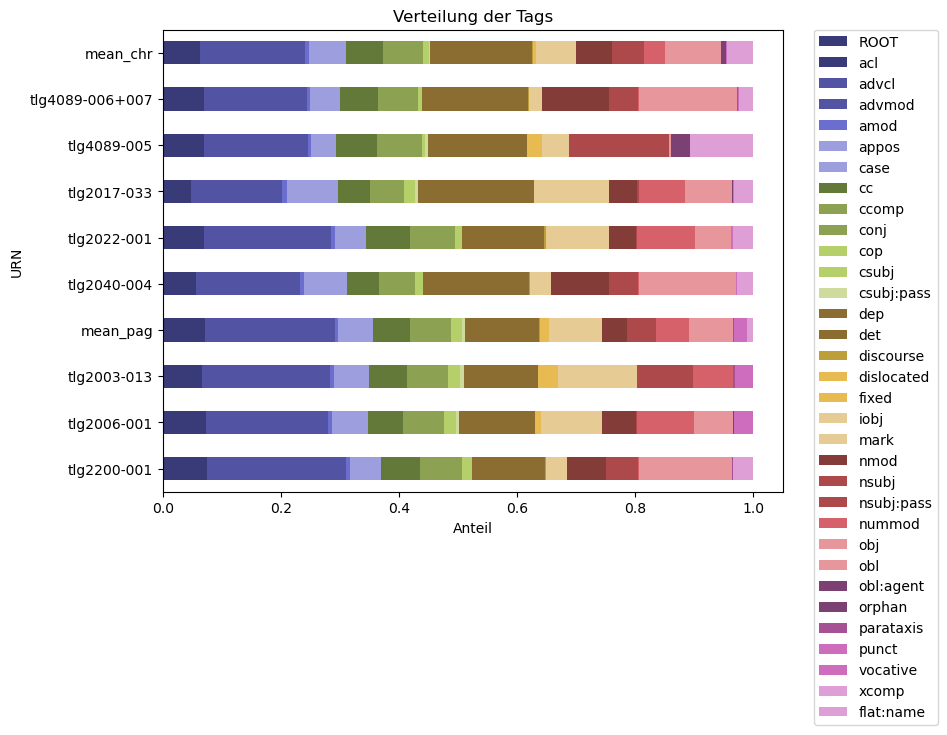

In [538]:
plot_feature(vergleich_syntax_letters)



## Alternative Programme (v.a. für Lemma-basierte Fragen)

- [Voyant Tools](https://voyant-tools.org/) (auch lokal zu installieren: <https://github.com/voyanttools/VoyantServer>)
- [AntConc](https://www.laurenceanthony.net/software/antconc/)